In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD   BTC-USD
Date                                                                
2014-09-17  457.334015  468.174011  452.421997  465.864014  21056800
2014-09-18  424.440002  456.859985  413.104004  456.859985  34483200
2014-09-19  394.795990  427.834991  384.532013  424.102997  37919700
2014-09-20  408.903992  423.295990  389.882996  394.673004  36863600
2014-09-21  398.821014  412.425995  393.181000  408.084991  26580100


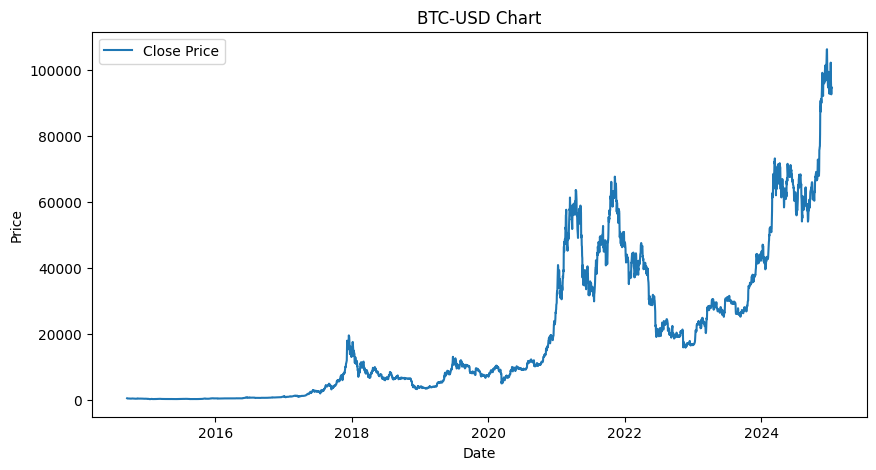

In [3]:
#Fetch data and create a price chart
ticker = "BTC-USD"
start_date = "2009-01-03"
end_date = "2025-01-12"
data = yf.download(ticker, start=start_date, end=end_date)

if data.empty:
    print("No data found")
else:
    print(data.head())

data.index = pd.to_datetime(data.index)

plt.figure(figsize=(10, 5))
plt.plot(data['Close'], label="Close Price")
plt.title(f"{ticker} Chart")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [4]:
# Verify the structure of my data and see if it has MultiIndex columns
print(data['Close'].head())
print(data['Close'].shape)

print(data.columns)

# Flatten the MultiIndex columns
# data.columns = data.columns.get_level_values(0) # Use the first level as the column name



Ticker         BTC-USD
Date                  
2014-09-17  457.334015
2014-09-18  424.440002
2014-09-19  394.795990
2014-09-20  408.903992
2014-09-21  398.821014
(3770, 1)
MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])


## 1. Volume vs. Price Heatmap

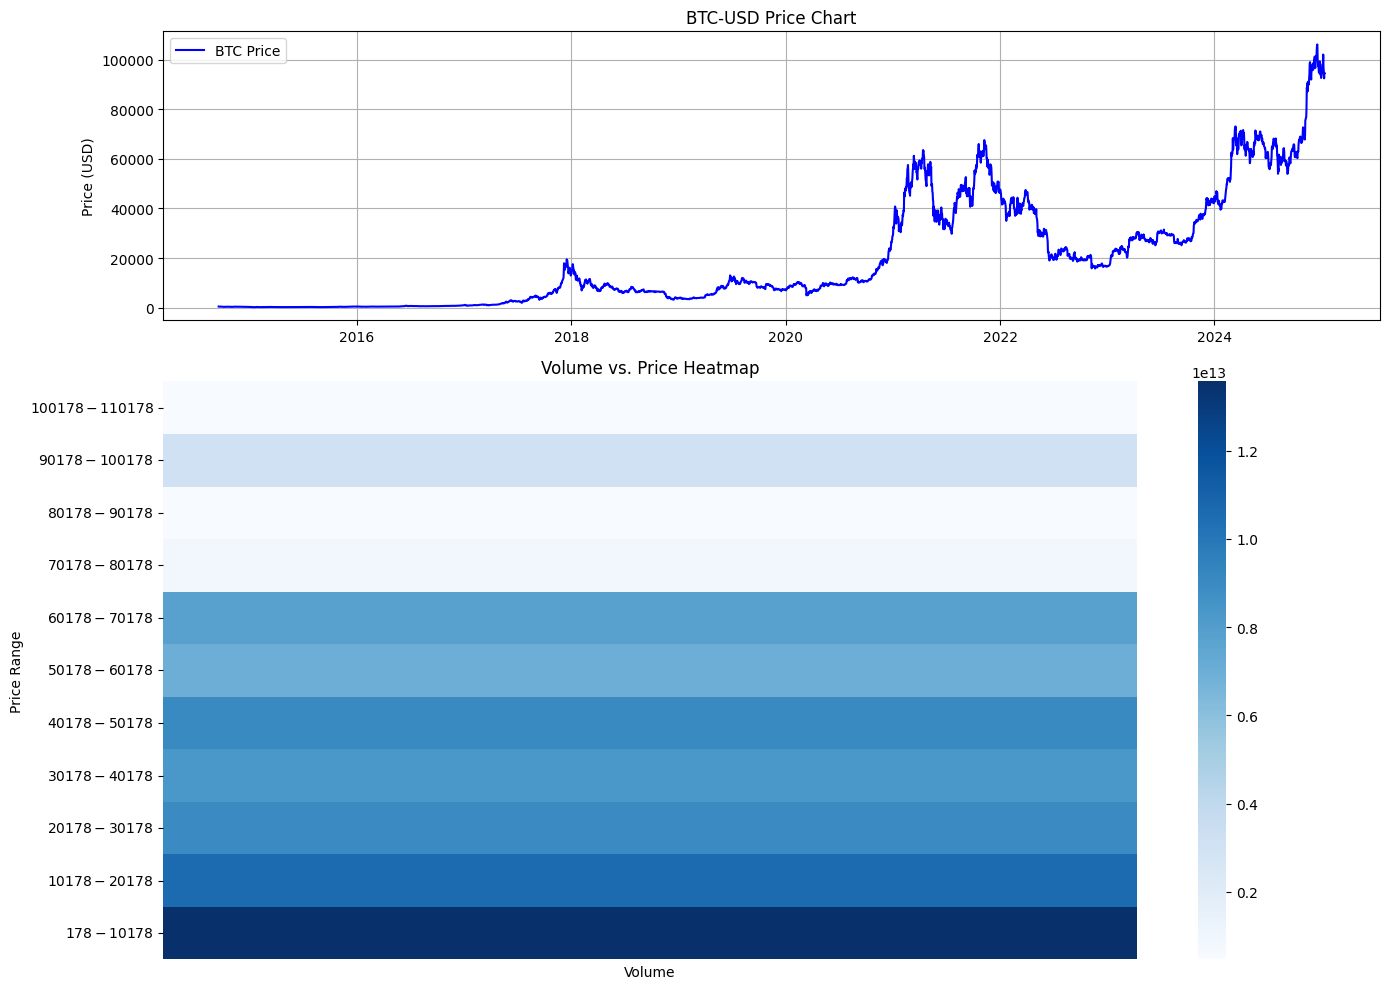

In [5]:
# Flatten the MultiIndex columns
data.columns = data.columns.get_level_values(0) # Use the first level as the column name

# Adjust price bins to 10000 increments
bin_width = 10000
price_min = data['Close'].min()
price_max = data['Close'].max()
bins = list(range(int(price_min), int(price_max) + bin_width, bin_width)) # Bin ranges

# Create price bins
data['Price Range'] = pd.cut(data['Close'], bins=bins, right=False) #Left inclusive bins
volume_by_price = data.groupby('Price Range')['Volume'].sum() #Sum volume per price range

# Prepare the heatmap data
heatmap_data = volume_by_price.reindex(data['Price Range'].cat.categories) #Ensure all bins are included

# Set up a combined figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 2]})

# 1. Price chart
ax1.plot(data.index, data['Close'], label="BTC Price", color="blue")
ax1.set_title("BTC-USD Price Chart")
ax1.set_ylabel("Price (USD)")
ax1.legend()
ax1.grid(True)

# 2. Heatmap
sns.heatmap(
    heatmap_data.values.reshape(-1, 1),
    cmap="Blues",
    annot=False,
    cbar=True,
    ax=ax2,
    xticklabels=False, #Hide x-tick labels (dates are clear from the price chart above)
    yticklabels=[f"${int(interval.left)}-${int(interval.right)}" for interval in heatmap_data.index]
)
ax2.set_title("Volume vs. Price Heatmap")
ax2.set_ylabel("Price Range")
ax2.set_xlabel("Volume")
ax2.invert_yaxis() #Ensure lowest price is at the bottom

plt.tight_layout()
plt.show()


## Price chart with Moving averages

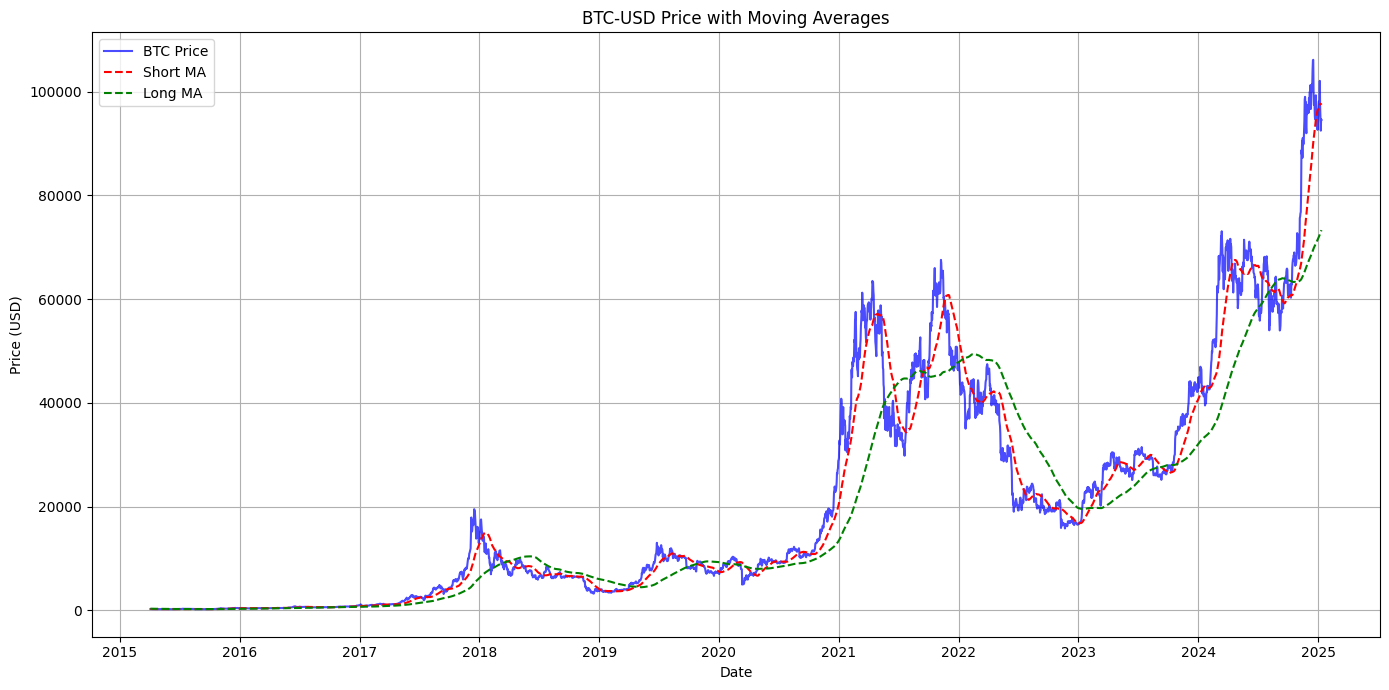

In [6]:
short_window = 50 # Short term MA
long_window = 200 # Long terma MA
data['Short MA'] = data['Close'].rolling(window=short_window).mean()
data['Long MA'] = data['Close'].rolling(window=long_window).mean()

# Drop rows with NaN values
data.dropna(inplace=True)

# Plot the price chart with moving averages
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label="BTC Price", color="blue", alpha=0.7)
plt.plot(data.index, data['Short MA'], label="Short MA", color="red", linestyle="--")
plt.plot(data.index, data["Long MA"], label="Long MA", color="green", linestyle="--")

# Chart formatting
plt.title("BTC-USD Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Bollinger Bands

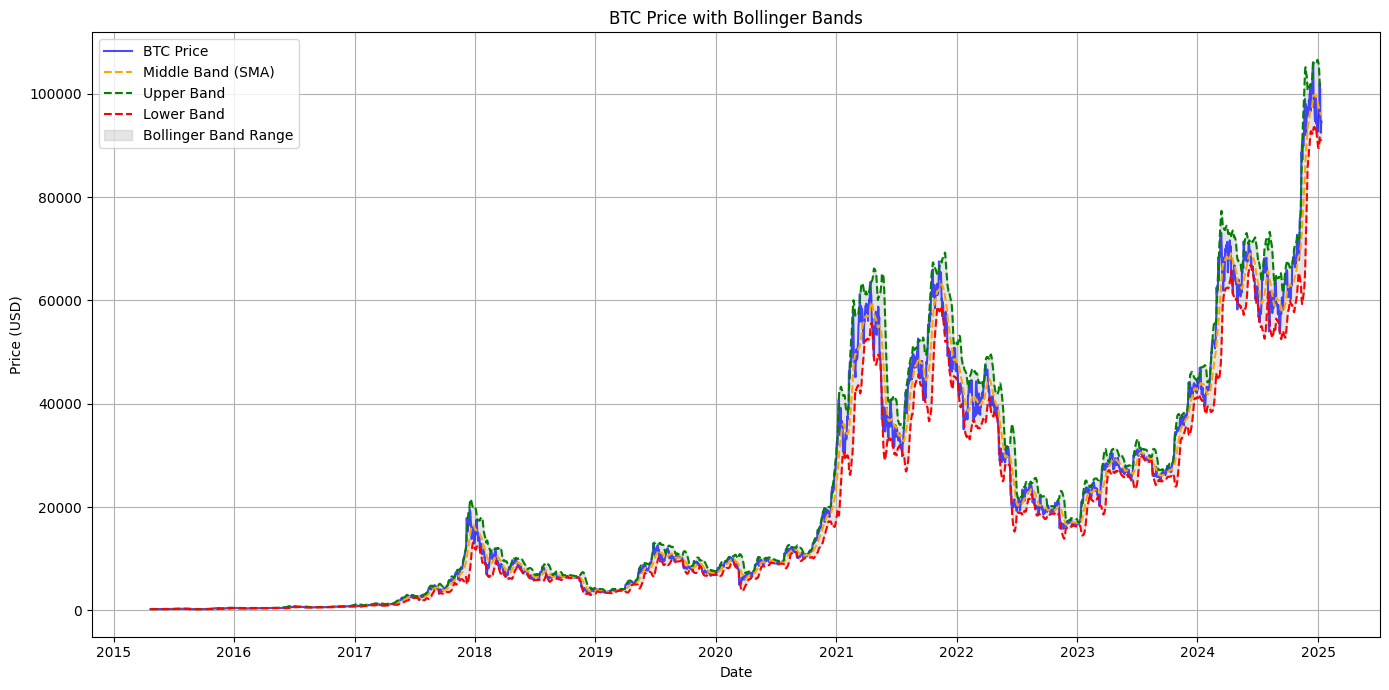

In [7]:
# Calculate Bollinger Bands
window = 20
data['Middle_Band'] = data['Close'].rolling(window=window).mean()
data['Upper_Band'] = data['Middle_Band'] + (data['Close'].rolling(window=window).std() * 2)
data['Lower_Band'] = data['Middle_Band'] - (data['Close'].rolling(window=window).std() * 2)

# Drop rows with NaN values
data.dropna(inplace=True)

# Plot BTC price with Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label="BTC Price", color="blue", alpha=0.7)
plt.plot(data.index, data['Middle_Band'], label="Middle Band (SMA)", color="orange", linestyle="--")
plt.plot(data.index, data['Upper_Band'], label="Upper Band", color="green", linestyle="--")
plt.plot(data.index, data['Lower_Band'], label="Lower Band", color="red", linestyle="--")

# Add fill between upper and lower bands
plt.fill_between(data.index, data['Upper_Band'], data['Lower_Band'], color="gray", alpha=0.2, label="Bollinger Band Range")

# Chart formatting
plt.title("BTC Price with Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Scatter plot of price vs. volume

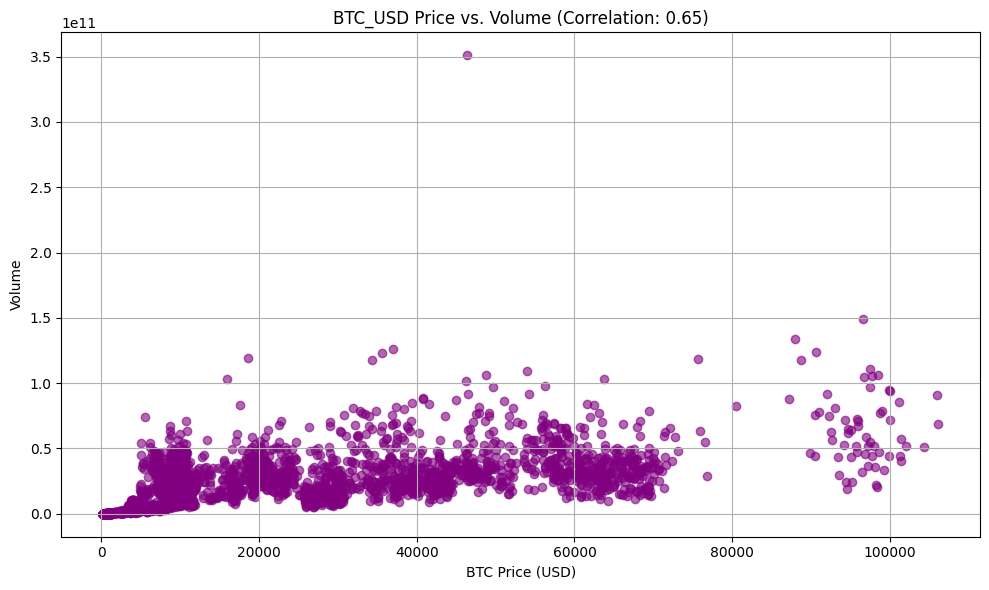

In [8]:
# Scatter plot for price vs. volume
plt.figure(figsize=(10, 6))

# Scatter the data
plt.scatter(data['Close'], data['Volume'], alpha=0.6, color="purple")

# Add correlation coefficient
correlation = data['Close'].corr(data['Volume'])
plt.title(f"BTC_USD Price vs. Volume (Correlation: {correlation:.2f})")
plt.xlabel("BTC Price (USD)")
plt.ylabel("Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
data.to_csv('btc_usd_data.csv', index=True)